# NYC MTA & Weather Data Analysis
___

With a cleaned MTA & weather dataset - let's bring them together to see what pleasant busy days look like in NYC.

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## 1. Import our nyc_mta dataset

In [133]:
# import our nyc_mta data
nyc_mta = pd.read_csv('./data/nyc_mta_data_cleaned.csv', parse_dates=['date'])

In [134]:
nyc_mta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42880 entries, 0 to 42879
Data columns (total 5 columns):
date               42880 non-null datetime64[ns]
station            42880 non-null object
line               42880 non-null object
division           42880 non-null object
daily_ridership    42880 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.6+ MB


We want to have a summarized ridership per day - let's group the dataframe to achieve this

In [135]:
nyc_mta_ridership = nyc_mta.groupby('date').daily_ridership.sum()
nyc_mta_ridership = nyc_mta_ridership.to_frame('ridership')
nyc_mta_ridership.head()

,ridership
date,
2016-07-31,2492668
2016-08-01,5172413
2016-08-02,5542629
2016-08-03,5687754
2016-08-04,5673306


## 2. Import our pleasant day nyc_weather data

In [141]:
# import our weather data
nyc_weather = pd.read_csv('./data/nyc_weather_pleasant_days.csv')
nyc_weather.columns=['month_day', 'avg_temp']

In [142]:
nyc_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
month_day    25 non-null object
avg_temp     25 non-null float64
dtypes: float64(1), object(1)
memory usage: 480.0+ bytes


We currently have the month/date within the nyc_weather dataframe.  Let's convert that to an actual datetime value

In [143]:
from dateutil.parser import parse

# let's conver the date into an acutal datetime 
nyc_weather['date'] = [parse(date + ' 2016') for date in nyc_weather['month_day']]
nyc_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
month_day    25 non-null object
avg_temp     25 non-null float64
date         25 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 680.0+ bytes


## 3. Graph two datasets together

Let's join the two datasets together and overlay the data on a single plot

In [164]:
import pandas as pd

# merge the data
nyc_mta_weather = pd.merge(nyc_weather, nyc_mta_ridership.reset_index(), on='date', how='left')


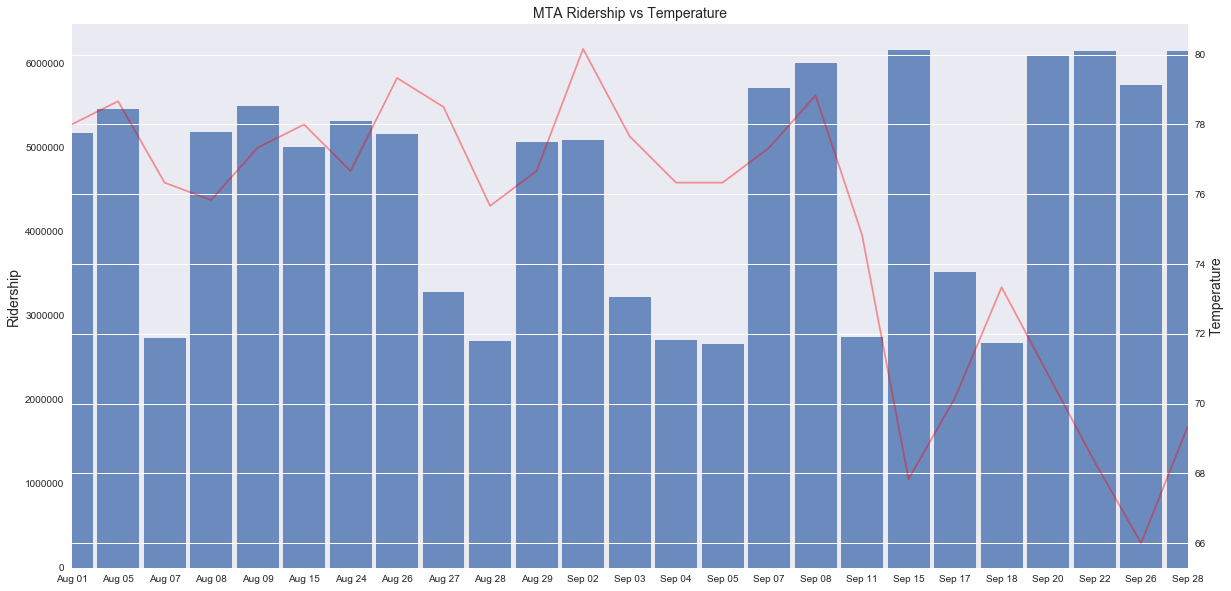

In [165]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(20,10))

# plot left axis
nyc_mta_weather['ridership'].plot(kind='bar', width = .9, alpha=0.8)

# setup left axis
plt.ylabel('Ridership', fontsize='14')
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1500000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nyc_mta_weather['avg_temp'].plot(secondary_y=True, color='r', alpha=0.4)

# set x ticks
start, end = ax.get_xlim()
plt.xticks(np.arange(start, end+1, 1), nyc_mta_weather['month_day'], rotation=85, fontsize='12')

plt.title('MTA Ridership vs Temperature', fontsize='14')
plt.xlabel('Dates', fontsize='14')
plt.ylabel('Temperature', fontsize='14')

plt.show()

Above we have the pleasant days overlayed on the ridership levels.  The dips can be explained as follows: 
* Weekends show a considerable drop in ridership: (Aug 7, 27, 28) (Sept 11, 17, 18)
* Labor day long weekend also result in a dip in ridership: Sept 3rd, 4th, 5th
